In [1]:
from crm import Network

In [156]:
import re
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange

# Data

In [3]:
f = open("data/raw/crm_output.pl")

In [4]:
edges_raw = []

In [5]:
while True:
    s = f.readline()
    if not s:
        break
    if "connected" in s:
        edges_raw.append(s)

In [6]:
edges_raw[-2]

'connected(a(2),[a(0),a(0)],[1,0]).\n'

In [7]:
edges_raw[24].split(",")[0].split("(")[-1].split(")")[0]

'1258'

In [8]:
gg = ' '.join(edges_raw[24].split(",")[1:3])

In [9]:
gg

'[a(2) a(26)]'

In [10]:
int(re.findall(r"a\([0-9]*\)", gg)[0].split("(")[-1].split(")")[0])

2

In [11]:
int(re.findall(r"a\([0-9]*\)", gg)[1].split("(")[-1].split(")")[0])

26

In [12]:
edges = []

In [13]:
int(edges_raw[0].split(",")[0].split("(")[-1].split(")")[0])-1

1281

In [14]:
for i in range(len(edges_raw)):
    end = int(edges_raw[i].split(",")[0].split("(")[-1].split(")")[0])-1
    
    gg = ' '.join(edges_raw[i].split(",")[1:3])
    start_one = int(re.findall(r"a\([0-9]*\)", gg)[0].split("(")[-1].split(")")[0])-1
    start_two = int(re.findall(r"a\([0-9]*\)", gg)[1].split("(")[-1].split(")")[0])-1
    # start_one --> end
    # start_two --> end
    if start_one!=-1:
        edges.append((start_one, end))
    if start_two!=-1:
        edges.append((start_two, end))

In [16]:
with open("data/edges.txt", "w") as fp:
    for u, v in edges:
        fp.write(f"{u} {v}\n")

In [17]:
len(edges), len(set(edges))

(2518, 2518)

In [87]:
inputs = []
outputs = []

In [88]:
f = open("data/raw/train_features_pos")

In [89]:
while True:
    gg = f.readline().split(" ")[3:-1]
    if not gg:
        break
    all_pos = [int(e) for e in gg]
    dd = {i: 1 if i in all_pos else 0 for i in range(1282)}
    inputs.append(dd)
    outputs.append(torch.tensor(1))

In [90]:
f = open("data/raw/train_features_neg")

In [91]:
while True:
    gg = f.readline().split(" ")[3:-1]
    if not gg:
        break
    all_pos = [int(e) for e in gg]
    dd = {i: 1 if i in all_pos else 0 for i in range(1282)}
    inputs.append(dd)
    outputs.append(torch.tensor(0))

In [30]:
num_neurons = max([max(u, v) for u, v in edges])+1

In [31]:
num_neurons

1282

In [34]:
adj_list = [[] for i in range(num_neurons)]

In [35]:
num_neurons

1282

In [36]:
len(adj_list)

1282

In [37]:
for u, v in edges:
    adj_list[u].append(v)

In [39]:
n = Network(num_neurons, adj_list)

In [40]:
orig_output_neurons = n.output_neurons

In [41]:
adj_list.append([])
adj_list.append([])

In [42]:
num_neurons = len(adj_list)

In [43]:
num_neurons

1284

In [44]:
for i in range(num_neurons):
    if i in orig_output_neurons:
        adj_list[i].append(num_neurons-2)
        adj_list[i].append(num_neurons-1)

In [45]:
adj_list[213]

[1282, 1283]

In [163]:
n = Network(num_neurons, adj_list)

In [164]:
n.set_neuron_activation(1282, lambda x : x, lambda x : 1)

In [165]:
n.set_neuron_activation(1283, lambda x : x, lambda x : 1)

In [166]:
F.cross_entropy

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

  0%|          | 0/700 [00:00<?, ?it/s]

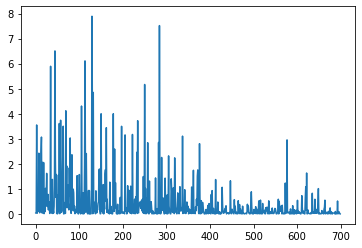

In [172]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = n.forward(f_mapper).reshape(1, -1)
    loss = F.cross_entropy(out, dataset[i][1].reshape(1))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    n.reset()
# print(n.weights)
plt.plot(losses)
plt.show()

In [148]:
n.reset()

In [152]:
dataset = [(inputs[i], outputs[i]) for i in range(len(inputs))]

In [170]:
random.shuffle(dataset)

In [171]:
dataset[21][1]

tensor(1)

In [173]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
correct = 0
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = n.forward(f_mapper).reshape(1, -1)
    correct += 1 if torch.argmax(out)==dataset[i][1] else 0
    n.reset()
print(correct/700*100)
# print(n.weights)
print(losses)
# plt.plot(losses)
# plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

98.42857142857143
[]


In [54]:
# https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function
import torch
for f in f_mapper_global:
    f[1282]=1
    f[1283]=1
    n.reset()
    o = n.forward(f)
    if o[0]!=torch.tensor([0.]):
        print(o)
        break

In [60]:
m = torch.nn.Sequential(torch.nn.Linear(10, 100))

In [72]:
list(m.parameters())[1]

Parameter containing:
tensor([ 0.2583, -0.2650, -0.1380,  0.2627, -0.0312,  0.1305, -0.2825,  0.2821,
        -0.1505, -0.1986,  0.1177, -0.0656, -0.2120,  0.2727,  0.2055,  0.2070,
         0.0710,  0.1732,  0.0441,  0.2178,  0.0877,  0.0890, -0.2641,  0.1323,
         0.2862,  0.1050, -0.0550,  0.0561,  0.1339,  0.1444, -0.1224,  0.0247,
        -0.2285, -0.1712,  0.2991,  0.2760,  0.3068, -0.2236,  0.1844,  0.2605,
         0.1401, -0.1417,  0.0496, -0.2446,  0.2426,  0.2560,  0.0176, -0.0214,
         0.0734, -0.2629, -0.1454, -0.0164, -0.2263, -0.1252,  0.2839,  0.1112,
        -0.1526, -0.2420,  0.1288, -0.2328, -0.1631, -0.2980, -0.2495,  0.0282,
         0.2589,  0.1794, -0.2060,  0.0578, -0.1831, -0.0485,  0.1794,  0.1493,
        -0.2882, -0.2283,  0.1230, -0.0346,  0.0167, -0.0178,  0.0618,  0.3064,
         0.2408, -0.1345,  0.1730,  0.0623,  0.2448,  0.2489,  0.2486, -0.2769,
         0.0622, -0.0840, -0.0709,  0.1767, -0.0693,  0.1541,  0.2729,  0.1055,
         0.1617, -

In [29]:
import torch

In [30]:
n = Network(4, [[1], [2], [3], []])
n.weights = {
        (0, 1): torch.tensor(1., requires_grad=True),
        (1, 2): torch.tensor(2., requires_grad=True),
        (2, 3): torch.tensor(3., requires_grad=True),
}

In [31]:
n.weights[(2, 3)], n.weights[(2, 3)].grad

(tensor(3., requires_grad=True), None)

In [32]:
n_o = n.forward({0:1, 1:1, 2:1, 3:1})

In [33]:
n_o

tensor([6.], grad_fn=<StackBackward>)

In [34]:
loss = 0.1*n_o*n_o/2

In [35]:
loss

tensor([1.8000], grad_fn=<DivBackward0>)

In [36]:
loss.backward()

In [37]:
n.weights[(2, 3)].grad

tensor(1.2000)

In [38]:
optimizer = torch.optim.Adam((v for v in n.weights.values()), lr=0.1)

In [39]:
optimizer.zero_grad()

In [40]:
n.weights[(2, 3)].grad

tensor(0.)

In [41]:
n.weights[(2, 3)], n.weights[(2, 3)].grad

(tensor(3., requires_grad=True), tensor(0.))

In [92]:
a.grad

tensor(30.)

In [87]:
torch.stack([o1, o2]).backward()

RuntimeError: grad can be implicitly created only for scalar outputs